<a href="https://colab.research.google.com/github/ManoharBandam/PSU/blob/master/NROTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [2]:
from torch._C import dtype
#!/usr/bin/python3

import numpy as np
from scipy import sparse, stats
from sklearn import linear_model
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import torch.utils.data as Data
import copy as cp
import torch
import torch.optim as optim
import torch.nn.functional as F
import collections


device = 'cuda' if torch.cuda.is_available() else 'cpu'
cats = [0, 1, 2, 3, 4]

def lr_scheduler(epoch):
	lr = 1e-3
	if epoch > 20:
		lr *= 1e-2
	elif epoch > 10:
		lr *= 1e-1
	print('Learning rate: ', lr)

	return lr

def test(net, Test_loader):

	net.eval()
	# test acc
	total = 0
	correct = 0
	with torch.no_grad():
		for step, (batch_x, batch_y) in enumerate(Test_loader):  # for each training step

			batch_x = batch_x.to(device)
			batch_y = batch_y.to(device, dtype=torch.long)

			prediction = net(batch_x)  # input x and predict based on x
			_, predicted = prediction.max(1)
			total += batch_y.size(0)
			correct += predicted.eq(batch_y).sum().item()

	print('test acc: {}'.format(correct / total))

def train(epoch, net, Train_loader):

	# Optimizer:
	optimizer = torch.optim.Adam(net.parameters(), lr=lr_scheduler(epoch)) # MNIST

	# Loss function
	loss_func = torch.nn.CrossEntropyLoss()

	# training
	loss_train = 0
	total = 0
	correct = 0

	net.train()
	for step, (batch_x, batch_y) in enumerate(Train_loader):  # for each training step

		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device, dtype=torch.long)

		prediction = net(batch_x)  # input x and predict based on x

		loss = loss_func(prediction, batch_y)  # must be (1. nn output, 2. target)
		loss_train += loss.item()

		optimizer.zero_grad()  # clear gradients for next train
		loss.backward()  # backpropagation, compute gradients
		optimizer.step()  # apply gradients

		_, predicted = prediction.max(1)
		total += batch_y.size(0)
		correct += predicted.eq(batch_y).sum().item()

	loss_train = loss_train / (step + 1)
	train_acc = correct / total
	print('epoch: {}, avg_train_loss: {}, training acc:{}'.format(epoch, loss_train, train_acc))

	return net

def classifiers(Train, labelsTrain, Test, labelsTest, classifier):
  N, D = Train.shape
  if classifier == 'SVM':
    clf = linear_model.SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, alpha=0.01, random_state=0) # MNIST
    clf.fit(Train, labelsTrain)
    pred = clf.predict(Test)
    acc = metrics.accuracy_score(labelsTest, pred)
    print("accuracy of SVM :", acc)
    confusion = metrics.confusion_matrix(labelsTest, pred)
    print(confusion)
  elif classifier == 'LR':
    clf = linear_model.SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.01, random_state=0) # MNIST
    clf.fit(Train, labelsTrain)
    pred = clf.predict(Test)
    acc = metrics.accuracy_score(labelsTest, pred)
    print(acc)
    confusion = metrics.confusion_matrix(labelsTest, pred)
    print(confusion)
  return acc

def KNN_detection(Train, labelsTrain, k=10):
  # inputs: training set features and labels, k (# nearest neighbors) 
  # output: indicators of conjectured malicious samples, 0-normal, 1-malicious, it has the same size as labelsTrain
  print("Label counts in train data:", collections.Counter(labelsTrain))

  # Fit knn model
  knn = NearestNeighbors(n_neighbors = k)
  knn.fit(Train)

  # distances and indexes of k-neaighbors from model outputs
  distances, indexes = knn.kneighbors(Train)
  # plot mean of k-distances of each observation
  # plt.plot(distances.mean(axis =1)) 

  # loop over all observations
  j = 0
  A = np.zeros(labelsTrain.shape)
  for row in indexes:
    temp = np.zeros(k)
    i = 0
    #print("intermediate mode details:", row,temp)
    for column in row:
      temp[i] = labelsTrain[int(column)]
      i += 1
    #print("intermediate mode details:", row,temp)
    mode, freq = stats.mode(temp, axis=None)
    #print("intermediate mode details:", mode,freq)    
    A[j] =  mode
    j += 1
  print("Label counts in knn predicted data:", collections.Counter(A))
  # print("predicted labels:",A)
  # print(A.dtype)
  # print(np.unique(A))
  # print(labelsTrain[np.logical_not(A)])
  # print(np.unique(labelsTrain[np.logical_not(A)]))

  # check if predicted label is same as actual label
  dp_detected = np.zeros(A.shape)
  # malicious samples, 0-normal, 1-malicious
  num_of_malicious = 0
  non_malicious_labels = []
  for i in range(len(labelsTrain)):
    if A[i] != labelsTrain[i]:
      dp_detected[i] = 1
      num_of_malicious += 1
    else:
      dp_detected[i] = 0
      non_malicious_labels.append(labelsTrain[i])
  # print("non_malicious_labels",list(set(non_malicious_labels)))
  # print("malicious samples:",dp_detected)
  # print("no of malicious samples:",num_of_malicious)
  # print("original samples:",labelsTrain)
  # print(dp_detected.dtype)
  # print(np.unique(dp_detected))
  # print(np.logical_not(dp_detected))
  # print(np.unique(np.logical_not(dp_detected)))
  # print(labelsTrain[np.logical_not(dp_detected)])
  # print(np.unique(labelsTrain[np.logical_not(dp_detected)]))
  return np.asarray(dp_detected)

def DataPoisoning(N0, N1, N2, N3, N4):
  # Ni: # malicious samples from class i
  # cats = [0,1,2,3,4]: 5 classes of MNIST
  
  Attack = [N0, N1, N2, N3, N4]

  # 1.load datasets
  transform_train = transforms.Compose([
    transforms.ToTensor(),
    ])
  transform_test = transforms.Compose([
		transforms.ToTensor(),
	])
  trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform_train)
  testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform_test)
  attackset = cp.copy(trainset)

	# 2. the experiments only involve 5 classes of MNIST [0, 1, 2, 3, 4]
	# split the training set, 2000 samples per class for training, 1000 samples per class for testing, 800 samples per class for poisoning
  NC = len(cats)
  nTrain = 2000
  nTest = 1000
  NAttack = 800

	# labels are stored in a list in datasets, convert it to numpy array
  trainset.targets = np.array(trainset.targets)
  attackset.targets = np.array(attackset.targets)
  testset.targets = np.array(testset.targets)
	# store indices of training samples and malicious samples
  ind_training = np.array([], dtype=int)
  ind_attack = np.array([], dtype=int)
  for c in cats:
		# randomly select NTrain+NAttack training samples from class c in [0,1,2,3,4]
    ind_c = np.where(trainset.targets == c)[0] 
    ind_c = np.random.choice(ind_c, nTrain+NAttack, False)
		# use a mask to split training samples and malicious samples
    mask = np.ones(ind_c.shape, dtype=bool)
    mask[:NAttack] = False
		# NTrain samples are used for training, NAttack samples are used for poisoning
    ind_training = np.concatenate((ind_training, ind_c[mask]))
    ind_attack = np.concatenate((ind_attack, ind_c[np.logical_not(mask)]))
	# extract samples by indices
  trainset.targets = trainset.targets[ind_training]
  trainset.data = trainset.data[ind_training]
  attackset.targets = attackset.targets[ind_attack]
  attackset.data = attackset.data[ind_attack]

	# store indices of test samples
  ind_test = np.array([], dtype=int)
	# only keep test samples from the 5 classes
  for c in cats:
    ind_c = np.where(testset.targets == c)[0]
    ind_test = np.concatenate((ind_test, ind_c))
  testset.targets = testset.targets[ind_test]
  testset.data = testset.data[ind_test]

	# groundtruth indicators of malicious samples, 0-normal, 1-malicious
  Attacks = np.zeros(trainset.targets.shape)

	# 3. poison the training set
	# Attack=[N0,N1,N2,N3,N4]
	# if Ni==1, then evenly distribute samples from class i of the attack set to the training sets of classes c!=i
  for j, attack in enumerate(Attack):
    print(cats[j], attack)
    if attack != 0:
      ind = np.where(attackset.targets == cats[j])[0]
      trainset.data = torch.cat([trainset.data, attackset.data[ind]], dim=0)
      Attacks = np.concatenate((Attacks, np.ones(attackset.targets[ind].shape)))
      label = np.array([])
      for i in cats:
        if i == cats[j]:
          continue
        label = np.concatenate((label, np.ones(int(NAttack/(NC-1)))*i))
        print('add {} labeled {}'.format(int(NAttack/(NC-1)), i))
      trainset.targets = np.concatenate((trainset.targets, label))

  # 4. form dataloader for CNN
  BATCH_SIZE = 32 
  EPOCH = 10
  Train_loader = Data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=1, )

  Test_loader = Data.DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=1, )

  # 5. train ResNet on the poisoned training set
  # function train(epoch, net, Train_loader)
  # function test(epoch, net, Test_loader)
  net = ResNet18(num_classes=NC)
  net.to(device)
  for epoch in range(EPOCH):
    net = train(epoch, net, Train_loader)
    test(net, Test_loader)
  # save model
  if not os.path.isdir('./models/'):
    os.makedirs('./models/')
  model_path = './models/poisoned_{}_{}_{}_{}_{}.pth'.format(N0, N1, N2, N3, N4)
  torch.save(net.state_dict(), model_path)

if __name__ == "__main__":
  DataPoisoning(N0=1, N1=1, N2=0, N3=1, N4=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

0 1
add 200 labeled 1
add 200 labeled 2
add 200 labeled 3
add 200 labeled 4
1 1
add 200 labeled 0
add 200 labeled 2
add 200 labeled 3
add 200 labeled 4
2 0
3 1
add 200 labeled 0
add 200 labeled 1
add 200 labeled 2
add 200 labeled 4
4 1
add 200 labeled 0
add 200 labeled 1
add 200 labeled 2
add 200 labeled 3
Learning rate:  0.001
epoch: 0, avg_train_loss: 0.9871396402181205, training acc:0.7202272727272727
test acc: 0.9861840825063242
Learning rate:  0.001
epoch: 1, avg_train_loss: 0.927586506050955, training acc:0.7412878787878788
test acc: 0.9918272037361354
Learning rate:  0.001
epoch: 2, avg_train_loss: 0.8995458806253808, training acc:0.7473484848484848
test acc: 0.9951352403191283
Learning rate:  0.001
epoch: 3, avg_train_loss: 0.8895965509351171, training acc:0.7496969696969698
test acc: 0.9935785172212492
Learning rate:  0.001
epoch: 4, avg_train_loss: 0.8754413803322263, training acc:0.7518181818181

In [3]:
from torch._C import dtype
#!/usr/bin/python3

import numpy as np
from scipy import sparse, stats
from sklearn import linear_model
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import torch.utils.data as Data
import copy as cp
import torch
import torch.optim as optim
import torch.nn.functional as F
import collections
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cats = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
counter = 0

def lr_scheduler(epoch):
	lr = 1e-3
	if epoch > 20:
		lr *= 1e-2
	elif epoch > 10:
		lr *= 1e-1
	print('Learning rate: ', lr)

	return lr

def test(net, Test_loader):

	net.eval()
	# test acc
	total = 0
	correct = 0
	with torch.no_grad():
		for step, (batch_x, batch_y) in enumerate(Test_loader):  # for each training step

			batch_x = batch_x.to(device)
			batch_y = batch_y.to(device, dtype=torch.long)

			prediction = net(batch_x)  # input x and predict based on x
			_, predicted = prediction.max(1)
			total += batch_y.size(0)
			correct += predicted.eq(batch_y).sum().item()

	print('test acc: {}'.format(correct / total))

def train(epoch, net, Train_loader):

	# Optimizer:
	optimizer = torch.optim.Adam(net.parameters(), lr=lr_scheduler(epoch)) # MNIST

	# Loss function
	loss_func = torch.nn.CrossEntropyLoss()

	# training
	loss_train = 0
	total = 0
	correct = 0

	net.train()
	for step, (batch_x, batch_y) in enumerate(Train_loader):  # for each training step

		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device, dtype=torch.long)

		prediction = net(batch_x)  # input x and predict based on x

		loss = loss_func(prediction, batch_y)  # must be (1. nn output, 2. target)
		loss_train += loss.item()

		optimizer.zero_grad()  # clear gradients for next train
		loss.backward()  # backpropagation, compute gradients
		optimizer.step()  # apply gradients

		_, predicted = prediction.max(1)
		total += batch_y.size(0)
		correct += predicted.eq(batch_y).sum().item()

	loss_train = loss_train / (step + 1)
	train_acc = correct / total
	print('epoch: {}, avg_train_loss: {}, training acc:{}'.format(epoch, loss_train, train_acc))

	return net

def classifiers(Train, labelsTrain, Test, labelsTest, classifier):
  N, D = Train.shape
  if classifier == 'SVM':
    clf = linear_model.SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, alpha=0.01, random_state=0) # MNIST
    clf.fit(Train, labelsTrain)
    pred = clf.predict(Test)
    acc = metrics.accuracy_score(labelsTest, pred)
    confusion = metrics.confusion_matrix(labelsTest, pred)
    # print("confusion matrix :")
    # print(confusion)
  elif classifier == 'LR':
    clf = linear_model.SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.01, random_state=0) # MNIST
    clf.fit(Train, labelsTrain)
    pred = clf.predict(Test)
    acc = metrics.accuracy_score(labelsTest, pred)
    # print(acc)
    confusion = metrics.confusion_matrix(labelsTest, pred)
    # print(confusion)
  return acc,confusion

def KNN_detection(Train, labelsTrain, k=10):
  # inputs: training set features and labels, k (# nearest neighbors) 
  # output: indicators of conjectured malicious samples, 0-normal, 1-malicious, it has the same size as labelsTrain
  print("Label counts in train data:")
  print(collections.Counter(labelsTrain))

  # Fit knn model
  knn = NearestNeighbors(n_neighbors = k)
  knn.fit(Train)

  # distances and indexes of k-neaighbors from model outputs
  distances, indexes = knn.kneighbors(Train)
  # plot mean of k-distances of each observation
  # plt.plot(distances.mean(axis =1)) 

  # loop over all observations
  j = 0
  A = np.zeros(labelsTrain.shape)
  for row in indexes:
    temp = np.zeros(k)
    i = 0
    #print("intermediate mode details:", row,temp)
    for column in row:
      temp[i] = labelsTrain[int(column)]
      i += 1
    #print("intermediate mode details:", row,temp)
    mode, freq = stats.mode(temp, axis=None)
    #print("intermediate mode details:", mode,freq)    
    A[j] =  mode
    j += 1
  print("Label counts in knn predicted data:")
  print(collections.Counter(A))
  # print("predicted labels:",A)
  # print(A.dtype)
  # print(np.unique(A))
  # print(labelsTrain[np.logical_not(A)])
  # print(np.unique(labelsTrain[np.logical_not(A)]))

  # check if predicted label is same as actual label
  dp_detected = np.zeros(A.shape)
  # malicious samples, 0-normal, 1-malicious
  num_of_malicious = 0
  non_malicious_labels = []
  for i in range(len(labelsTrain)):
    if A[i] != labelsTrain[i]:
      dp_detected[i] = 1
      num_of_malicious += 1
    else:
      dp_detected[i] = 0
      non_malicious_labels.append(labelsTrain[i])
  # print("non_malicious_labels",list(set(non_malicious_labels)))
  # print("malicious samples:",dp_detected)
  # print("no of malicious samples:",num_of_malicious)
  # print("original samples:",labelsTrain)
  # print(dp_detected.dtype)
  # print(np.unique(dp_detected))
  # print(np.logical_not(dp_detected))
  # print(np.unique(np.logical_not(dp_detected)))
  # print(labelsTrain[np.logical_not(dp_detected)])
  # print(np.unique(labelsTrain[np.logical_not(dp_detected)]))
  return np.asarray(dp_detected)

def DataPoisoning(N0, N1, N2, N3, N4, N5, N6, N7, N8, N9):
	# Ni: # malicious samples from class i
	# cats = [0,1,2,3,4]: 5 classes of MNIST

	Attack = [N0, N1, N2, N3, N4, N5, N6, N7, N8, N9]

	# 1.load datasets
	transform_train = transforms.Compose([
		transforms.ToTensor(),
	])
	transform_test = transforms.Compose([
		transforms.ToTensor(),
	])
	trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform_train)
	testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform_test)
	attackset = cp.copy(trainset)

	# 2. the experiments only involve 5 classes of MNIST [0, 1, 2, 3, 4]
	# split the training set, 2000 samples per class for training, 1000 samples per class for testing, 800 samples per class for poisoning
	NC = len(cats)
	nTrain = 4000
	nTest = 1000
	NAttack = 900

	# labels are stored in a list in datasets, convert it to numpy array
	trainset.targets = np.array(trainset.targets)
	attackset.targets = np.array(attackset.targets)
	testset.targets = np.array(testset.targets)
	# store indices of training samples and malicious samples
	ind_training = np.array([], dtype=int)
	ind_attack = np.array([], dtype=int)
	for c in cats:
		# randomly select NTrain+NAttack training samples from class c in [0,1,2,3,4]
		ind_c = np.where(trainset.targets == c)[0] 
		ind_c = np.random.choice(ind_c, nTrain+NAttack, False)
		# use a mask to split training samples and malicious samples
		mask = np.ones(ind_c.shape, dtype=bool)
		mask[:NAttack] = False
		# NTrain samples are used for training, NAttack samples are used for poisoning
		ind_training = np.concatenate((ind_training, ind_c[mask]))
		ind_attack = np.concatenate((ind_attack, ind_c[np.logical_not(mask)]))
	# extract samples by indices
	trainset.targets = trainset.targets[ind_training]
	trainset.data = trainset.data[ind_training]
	attackset.targets = attackset.targets[ind_attack]
	attackset.data = attackset.data[ind_attack]

	# store indices of test samples
	ind_test = np.array([], dtype=int)
	# only keep test samples from the 5 classes
	for c in cats:
		ind_c = np.where(testset.targets == c)[0]
		ind_test = np.concatenate((ind_test, ind_c))
	testset.targets = testset.targets[ind_test]
	testset.data = testset.data[ind_test]

	# groundtruth indicators of malicious samples, 0-normal, 1-malicious
	Attacks = np.zeros(trainset.targets.shape)

	# 3. poison the training set
	# Attack=[N0,N1,N2,N3,N4]
	# if Ni==1, then evenly distribute samples from class i of the attack set to the training sets of classes c!=i
	for j, attack in enumerate(Attack):
		print(cats[j], attack)
		if attack != 0:
			ind = np.where(attackset.targets == cats[j])[0]
			trainset.data = torch.cat([trainset.data, attackset.data[ind]], dim=0)
			Attacks = np.concatenate((Attacks, np.ones(attackset.targets[ind].shape)))
			label = np.array([])
			for i in cats:
				if i == cats[j]:
					continue
				label = np.concatenate((label, np.ones(int(NAttack/(NC-1)))*i))
				print('add {} labeled {}'.format(int(NAttack/(NC-1)), i))
			trainset.targets = np.concatenate((trainset.targets, label))

	return trainset, testset, Attacks

def main(N0, N1, N2, N3, N4, N5, N6, N7, N8, N9, classifier='SVM'):
  
  # 1. poison training set
  # Attacks: groundtruth indicators of malicious samples, 0-normal, 1-malicious
  # Note: it cannot be used in anomaly detection. we only use it in performance evaluation
  trainset, testset, Attacks = DataPoisoning(N0, N1, N2, N3, N4, N5, N6, N7, N8, N9)
  NC = len(cats)
  
  print("trainset:",len(trainset))
  print("testset:",len(testset))
  print("Attacks:",len(Attacks))
  # flatten feature matrix, N*28*28 => N*784
  features_train = trainset.data.numpy().reshape(len(trainset.targets), -1)
  features_test = testset.data.numpy().reshape(len(testset.targets), -1)
  
  # 2. poisoned acc
  if classifier == 'SVM' or classifier == 'LR':
    acc, cm = classifiers(features_train, trainset.targets, features_test, testset.targets, classifier)
    # plot_confusion_matrix(cm, cats, "confusion matrix poisoned")
    fig2 = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    print("accuracy with poisoned data :", acc)
    print(cm)
  else:
    BATCH_SIZE = 32
    Train_loader_poisoned = Data.DataLoader(
        dataset=trainset,
        batch_size = BATCH_SIZE,
        shuffle=True, num_workers=1, )
    Test_loader = Data.DataLoader(
        dataset=testset,
        batch_size = BATCH_SIZE,
        shuffle=True, num_workers=1, )
    EPOCH = 10
    model_path = './models/KNN_sanitized_{}_{}_{}_{}_{}.pth'.format(N0, N1, N2, N3, N4)
    print("#######################")
    net1 = ResNet18(num_classes=NC)
    net1.to(device)
    for epoch in range(EPOCH):
      net1 = train(epoch, net1, Train_loader_poisoned)
      test(net1, Test_loader)
  
  # 3. KNN-based detector
  # TODO
  # inputs: training set features and labels, k(# nearest neighbors)
  # output: A, indicators of conjectured malicious samples, 0-normal, 1-malicious, it has the same size as trainset.targets
  A = KNN_detection(features_train, trainset.targets, k=10)
  
  # 4. performance of the anomaly detector
  # 1)True positive rate(tpr): # truly detected malicious samples/ total # malicious samples
  # 2)False positive rate(fpr): # falsely detected malicious samples/ total # nomal samples
  # 3)acc of the classifier trained on the sanitized dataset(with detected malicious samples removed)

  TrueAttack = A*Attacks
  FalseAttack = A*np.logical_not(Attacks)
  if N0 + N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9 != 0:
    tpr = TrueAttack.sum()/(Attacks.sum())
  else:
    tpr = 0
  fpr = FalseAttack.sum()/((1-Attacks).sum())
  print("tpr: {}, fpr: {}".format(tpr, fpr))
  
  if classifier == 'SVM' or classifier == 'LR':
    acc2, cm2 = classifiers(features_train[np.logical_not(A)], trainset.targets[np.logical_not(A)], features_test, testset.targets, classifier)
    plot_confusion_matrix(cm2, cats, "confusion matrix for defense")
    print("accuracy with defense:", acc2)
    print(cm2)
  else:
    BATCH_SIZE = 32
    trainset.data = trainset.data[np.logical_not(A)]
    trainset.targets = trainset.targets[np.logical_not(A)]
    Train_loader_defense = Data.DataLoader(
        dataset=trainset,
        batch_size = BATCH_SIZE,
        shuffle=True, num_workers=1, )
    EPOCH = 10
    model_path = './models/KNN_sanitized_{}_{}_{}_{}_{}.pth'.format(N0, N1, N2, N3, N4)
    print("#######################")
    net = ResNet18(num_classes=NC)
    net.to(device)
    for epoch in range(EPOCH):
      net = train(epoch, net, Train_loader_defense)
      test(net, Test_loader)
    # torch.save(net.state_dict(), model_path)

if __name__ == "__main__":
	main(N0=1, N1=1, N2=1, N3=1, N4=1, N5 = 1, N6 = 1, N7 = 1, N8 = 1, N9 = 1, classifier='ResNet18')

0 1
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
1 1
add 100 labeled 0
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
2 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
3 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
4 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
5 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
6 1


0 1
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
1 1
add 100 labeled 0
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
2 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
3 0
4 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 5
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
5 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 6
add 100 labeled 7
add 100 labeled 8
add 100 labeled 9
6 0
7 1
add 100 labeled 0
add 100 labeled 1
add 100 labeled 2
add 100 labeled 3
add 100 labeled 4
add 100 labeled 5
add 100 labeled 6
add 100 labeled 8
add 100 labele

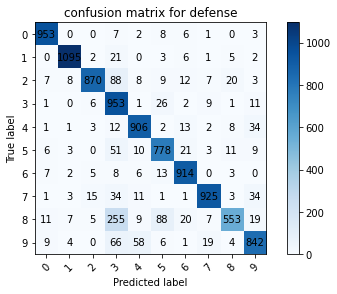

In [6]:
if __name__ == "__main__":
	main(N0=1, N1=1, N2=1, N3=0, N4=1, N5 = 1, N6 = 0, N7 = 1, N8 = 1, N9 = 1, classifier='SVM')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=0)
trainset, testset, Attacks = DataPoisoning(1, 1, 1, 1, 0)
tsne_res = tsne.fit_transform(trainset)

sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = label, palette = sns.hls_palette(10), legend = 'full');

In [ ]:
A = [1, 0, 0, 1, 1, 1]
B = [0, 0, 0, 4, 4, 4]
np.logical_not(A)


array([False,  True,  True, False, False, False])

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.close()
    # plt.figure().clear()


In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
dp_detected = np.zeros(10)
# malicious samples, 0-normal, 1-malicious
for i in range(10):
  if i%2 == 0:
    dp_detected[i] = 1
  else:
    dp_detected[i] = 0
print("malicious samples:",dp_detected)
print(dp_detected.dtype)
print(np.unique(dp_detected))
# print(labelsTrain[np.logical_not(dp_detected)])
# print(np.unique(labelsTrain[np.logical_not(dp_detected)]))

malicious samples: [1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
float64
[0. 1.]


In [ ]:
myList = ['Arise', 'But', 'It', 'Juliet', 'Who', 'already', 'and', 'and', 'and', 
     'breaks', 'east', 'envious', 'fair', 'grief', 'is', 'is', 'is', 'kill', 'light', 
     'moon', 'pale', 'sick', 'soft', 'sun', 'sun', 'the', 'the', 'the', 
     'through', 'what', 'window', 'with', 'yonder']


['Juliet',
 'yonder',
 'window',
 'It',
 'east',
 'through',
 'breaks',
 'soft',
 'light',
 'what',
 'fair',
 'and',
 'is',
 'sick',
 'sun',
 'Who',
 'the',
 'But',
 'already',
 'kill',
 'moon',
 'Arise',
 'grief',
 'pale',
 'envious',
 'with']

#LR k=10
0.6349484335473827
[[725   0 225  16  14]
 [ 25 108 559 167 276]
 [ 26   0 904  48  54]
 [ 57   6 334 581  32]
 [  3   0  31   3 945]]
Label counts in train data:
Counter({4.0: 2800, 0.0: 2600, 1.0: 2600, 2.0: 2600, 3.0: 2600})
Label counts in knn predicted data:
Counter({1.0: 2880, 0.0: 2861, 3.0: 2735, 2.0: 2724, 4.0: 2000})
tpr: 0.985625, fpr: 0.0167
0.9449309204125316
[[ 967    0    3    4    6]
 [   1 1024   58   49    3]
 [  26    3  942   36   25]
 [  12    0   26  963    9]
 [   1    3   14    4  960]]

#SVM k=15
accuracy of SVM : 0.667639618602841
confusion matrix :
[[125  73 168 466 148]
 [  0 772  65  10 288]
 [  6  18 899  52  57]
 [  4  12  81 719 194]
 [  1   4  57   4 916]]
Label counts in train data:
Counter({4.0: 2800, 0.0: 2600, 1.0: 2600, 2.0: 2600, 3.0: 2600})
Label counts in knn predicted data:
Counter({1.0: 2887, 0.0: 2841, 3.0: 2734, 2.0: 2727, 4.0: 2011})
tpr: 0.986875, fpr: 0.0161
accuracy of SVM : 0.9575792955827982
confusion matrix :
[[ 947    0    8   18    7]
 [   0 1128    4    3    0]
 [  17   23  927   43   22]
 [   7    5   29  965    4]
 [   0   13    8    7  954]]

#SVM k=10
accuracy of SVM : 0.72193033664137
confusion matrix :
[[705 115  24   7 129]
 [  0 730 359  25  21]
 [ 19 112 796  27  78]
 [  8 304 103 524  71]
 [  2  17   6   2 955]]
Label counts in train data:
Counter({4.0: 2800, 0.0: 2600, 1.0: 2600, 2.0: 2600, 3.0: 2600})
Label counts in knn predicted data:
Counter({1.0: 2896, 0.0: 2845, 3.0: 2737, 2.0: 2731, 4.0: 1991})
tpr: 0.9840625, fpr: 0.0165
accuracy of SVM : 0.9560225724849193
confusion matrix :
[[ 969    0    5    4    2]
 [   1 1117    4   12    1]
 [  43   11  914   48   16]
 [  13    2   20  970    5]
 [   7    3   20    9  943]]

#SVM k=5
accuracy of SVM : 0.7501459427904261
confusion matrix :
[[668  77 206  10  19]
 [150 924  33   0  28]
 [ 79  77 826  14  36]
 [ 86 212 174 499  39]
 [  5   8  31   0 938]]
Label counts in train data:
Counter({4.0: 2800, 0.0: 2600, 1.0: 2600, 2.0: 2600, 3.0: 2600})
Label counts in knn predicted data:
Counter({1.0: 2884, 0.0: 2872, 3.0: 2735, 2.0: 2709, 4.0: 2000})
tpr: 0.9834375, fpr: 0.0181
accuracy of SVM : 0.9612765129402607
confusion matrix :
[[ 960    1   14    4    1]
 [   2 1125    7    1    0]
 [   7   14  977   18   16]
 [  15   11   50  929    5]
 [   5    7   16    5  949]]